# Implementation of the SiPM response functions

This repository attempts to implement the SiPM low light response functions
describe in [arXiv:1609.01181][sipm_response] in a python library to allow for
the interfacing with the broader data analysis tools used by HEP. In this
notebook we will mainly break down the mathematical components that go into the
description given in the paper. And these functions are implemented in the
`sipmpdf.functions` module.

[sipm_response]: https://arxiv.org/pdf/1609.01181.pdf


In [1]:
import sipmpdf
import matplotlib.pyplot as plt
import numpy as np
import mplhep
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

## The generalized Poisson distribution

The [Generalized Poisson distribution][gen_poisson] $GP(x;\mu,\lambda)$ is used
to model the deviation from a simple Poisson distribution due to in-time
correlated discharged driven by optical crosstalk within the SiPM.

$$
GP(k;\mu\lambda) = \frac{\mu(\mu + \lambda x)^{k-1}}{k!}\exp(-(\mu+\lambda x))
$$

This function is implemented as `sipmpdf.functions.generalized_poisson`.

[gen_poisson]: https://www.jstor.org/stable/1267389


Text(0, 0.5, 'Probablity')

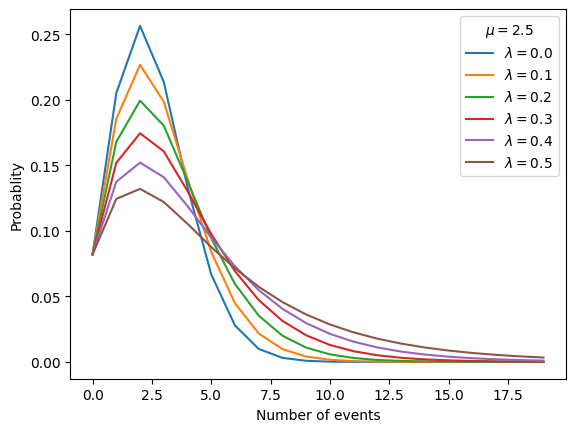

In [2]:
n = np.arange(20)
mu = 2.5

for idx, borel in enumerate([0.0, 0.1, 0.2, 0.3, 0.4, 0.5]):
  plt.plot(n,
           sipmpdf.functions.generalized_poisson(n, mu, borel),
           color=COLORS[idx],
           label=f'$\lambda={borel}$')
plt.legend(title='$\mu=2.5$')
plt.xlabel('Number of events')
plt.ylabel('Probablity')

## A Gaussian smeared General Poisson distribution

Here we provide a model that excludes other nonlinear effects other than cross
talk. This is given by the convolution of the General Poisson distribution
smeared by a Gaussian noise. The PDF of this model is given as: 

$$
P(x;p, g, \mu, \lambda, \sigma_0, \sigma_1) = 
\sum_{n=0}^{\infty} GP(n;\mu,\lambda) \cdot  
N(x; p + ng, \sqrt{\sigma_0^2 + p\sigma_1^2})
$$

Where $GP$ is the general poisson distribution (shown previously), and
$N(x;m,\sigma)$ is the Gaussian distribution a mean value $m$ and standard
deviation $\sigma$. 

[2000.]
[-100.          -99.49974987  -98.99949975 ...  898.99949975  899.49974987
  900.        ] [4.87634153e-13 6.08710458e-13 7.59004548e-13 ... 1.12990136e-03
 1.13160600e-03 1.13217479e-03]


Text(30, 0.0005927525971697379, '')

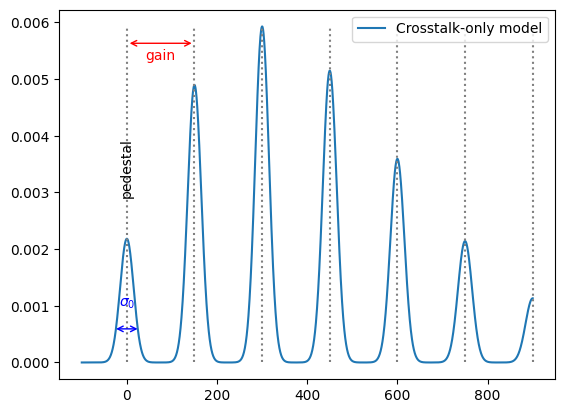

In [3]:
x = np.linspace(-100, 900, 2000)
y = sipmpdf.functions.normal_smeared_poisson(x,
                                             pedestal=0,
                                             gain=150,
                                             common_noise=15,
                                             pixel_noise=2,
                                             poisson_mean=2.5,
                                             poisson_borel=0.1)
print(x, y)
plt.plot(x, y, label=f'Crosstalk-only model')
ymax = np.max(y)
plt.legend()
#plt.yscale('log')
plt.vlines(150 * np.arange(7),
           ymin=0,
           ymax=np.max(y),
           color='gray',
           linestyles='dotted')
plt.annotate('pedestal', [0, ymax * 0.5], rotation=90, ha='center')
plt.annotate('gain', [75, ymax * 0.9], ha='center', color='red')
plt.annotate('',
             xy=(0, ymax * 0.95),
             xytext=(150, ymax * 0.95),
             arrowprops=dict(arrowstyle='<->', color='red'))

plt.annotate('$\sigma_0$', [0, 0.001], ha='center', color='blue')
plt.annotate('',
             xy=(-30, ymax * 0.1),
             xytext=(30, ymax * 0.1),
             arrowprops=dict(arrowstyle='<->', color='blue'))


Though this will not be official supported, the user can implement a simple
z-fit PDF to use this model. We are going to give a stand along example here, as
the full response function is even more expensive to compute. Notice since the
evaluation of functions is expensive, users should attempt to use a binned fit
where ever possible. Here we first declare the objects required for the fit:

In [4]:
import zfit


# Simple declaration of the zfit PDF
class DemoSiPMPDF(zfit.pdf.ZPDF):
  _N_OBS = 1
  _PARAMS = [
    'pedestal', 'gain', 'common_noise', 'pixel_noise', 'poisson_mean',
    'poisson_borel'
  ]

  def _unnormalized_pdf(self, x):
    x = zfit.z.unstack_x(x)
    return sipmpdf.functions.normal_smeared_poisson(
      x, **{k: self.params[k]
            for k in self._PARAMS})


# Declaring the variables of interest
pedestal = zfit.Parameter('pedestal', 5.0, -10, 50)
gain = zfit.Parameter('gain', 150.0, 100, 200)
common_noise = zfit.Parameter('common_nose', 15.0, 5, 25)
pixel_noise = zfit.Parameter('pixel_noise', 2.0, 1, 3)
poisson_mean = zfit.Parameter('poisson_mean', 2.5, 2, 3)
poisson_borel = zfit.Parameter('poisson_borel', 0.0, 0, 0.1)
obs = zfit.Space('x', limits=(-200, +1500))

# Declaring the "unbinned" PDF
pdf = DemoSiPMPDF(obs=obs,
                  pedestal=pedestal,
                  gain=gain,
                  common_noise=common_noise,
                  pixel_noise=pixel_noise,
                  poisson_mean=poisson_mean,
                  poisson_borel=poisson_borel)

# Declaring the binned phase space in PDF
binning = zfit.binned.RegularBinning(400, -200, 1800, name="x")
obs_bin = zfit.Space("x", binning=binning)
pdf_bin = zfit.pdf.BinnedFromUnbinnedPDF(pdf, obs_bin)


/home/ensc/VirtualENV/sipmenv/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/home/ensc/VirtualENV/sipmenv/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Then we can generate pseudo data using the random number generation provided in
numpy.


In [5]:
# Number of discharges following the regular Poisson distribution
n_pe = np.random.poisson(lam=2.5, size=100_000)
# For each discharge there is a set random uncertainty
noise = np.sqrt(15.0**2 + n_pe * 2.0**2)
# We run a second smearing using the random normal distribution
data_array = np.random.normal(size=100_000, loc=n_pe * 150 + 5, scale=noise)

# First we construct the unbinned data
data_unbinned = zfit.Data.from_numpy(obs=obs, array=data_array)
# Then the binned data
data_bin = data_unbinned.to_binned(obs_bin)


Next we can run the minizer:

In [6]:
nll_bin = zfit.loss.BinnedNLL(pdf_bin, data_bin)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_bin)
result.hesse()
result

Tensor("integrate_simpson_composite/boolean_mask/GatherV2:0", shape=(None,), dtype=int32)


/home/ensc/VirtualENV/sipmenv/lib/python3.8/site-packages/sipmpdf/kernel.py:75: UserWarning: Using tensorflow.experimental.numpy.sum. Make sure the functionality has been implemented!
  warnings.warn(


Tensor("integrate_simpson_composite/boolean_mask/GatherV2:0", shape=(None,), dtype=int32)


/home/ensc/VirtualENV/sipmenv/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1180: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")


FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7f24b985be20>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7f24b9797340>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.7e-05 │ 835.8425    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)        hesse    at limit
-------------  ------------------  -----------  ----------
pedestal                  5.04937  +/-    0.09       False
gain                      149.993  +/-   0.031       False
common_nose               14.9222  +/-   0.065       False
pixel_noise                2.0968  +/-    0.16       False
poisson_mean              2.50081  +/-  0.0075       False
poisson_bo

We can also invoke the various facility to plot the fit results:

tf.Tensor([2000], shape=(1,), dtype=int32)


tf.Tensor([993], shape=(1,), dtype=int32)


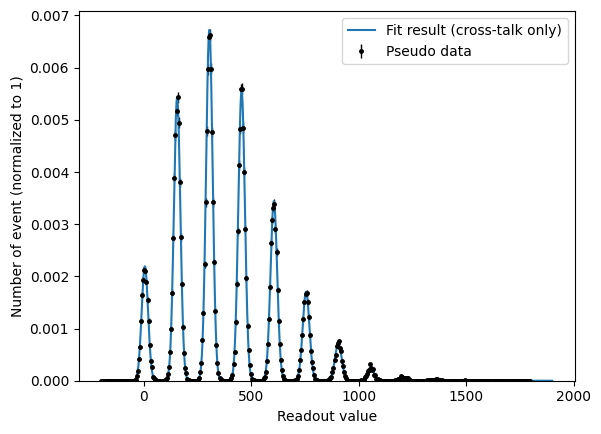

In [7]:
h = data_bin.to_hist()  # Converting to a histogram container
x = np.linspace(-100, 1900, 2000)
y = zfit.run(pdf.pdf(x))

ax = mplhep.histplot(h,
                     density=True,
                     label='Pseudo data',
                     histtype='errorbar',
                     color='k',
                     markersize=5)
plt.plot(x, y, label='Fit result (cross-talk only)')
plt.xlabel('Readout value')
plt.ylabel('Number of event (normalized to 1)')
plt.legend()


## Afterpulse response

Under construction

## Dark current response

Under construction